In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax
#jax.config.update('jax_default_device', jax.devices('cpu')[0])

from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np
import healpy as hp

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_default_matmul_precision', jax.lax.Precision.HIGHEST)


In [2]:
from jaxinterp2d import interp2d, CartesianGrid

H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0

zMax = 5
zgrid = jnp.expm1(jnp.linspace(jnp.log(1), jnp.log(zMax+1), 500))
Om0grid = jnp.linspace(Om0Planck-0.1,Om0Planck+0.1,50)

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value

rs = []
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

100%|██████████| 50/50 [00:00<00:00, 82.04it/s]


In [10]:
@jit
def dV_of_z_normed(z,Om0,gamma):
    dV = dV_of_z(zgrid,H0Planck,Om0)*(1+zgrid)**(gamma-1)
    prob = dV/jnp.trapezoid(dV,zgrid)
    return jnp.interp(z,zgrid,prob)


In [11]:
from jax.scipy.stats import norm

mass = jnp.linspace(1, 250, 2000)
mass_ratio =  jnp.linspace(0, 1, 2000)

def Sfilter_low(m,m_min,dm_min):
    """
    Smoothed filter function

    See Eq. B5 in https://arxiv.org/pdf/2111.03634.pdf
    """
    def f(mm,deltaMM):
        return jnp.exp(deltaMM/mm + deltaMM/(mm-deltaMM))

    S_filter = 1./(f(m-m_min,dm_min) + 1.)
    S_filter = jnp.where(m<m_min+dm_min,S_filter,1.)
    S_filter = jnp.where(m>m_min,S_filter,0.)
    return S_filter

def Sfilter_high(m,m_max,dm_max):
    """
    Smoothed filter function

    See Eq. B5 in https://arxiv.org/pdf/2111.03634.pdf
    """
    def f(mm,deltaMM):
        return jnp.exp(deltaMM/mm + deltaMM/(mm-deltaMM))

    S_filter = 1./(f(m-m_max,-dm_max) + 1.)
    S_filter = jnp.where(m>m_max-dm_max,S_filter,1.)
    S_filter = jnp.where(m<m_max,S_filter,0.)
    return S_filter

@jit
def logpm1_powerlaw(m1,m_min,m_max,alpha,dm_min,dm_max):

    pm1 = Sfilter_low(mass,m_min,dm_min)*mass**(-alpha)*Sfilter_high(mass,m_max,dm_max)
    pm1 = pm1/jnp.trapezoid(pm1,mass)
    return jnp.log(jnp.interp(m1,mass,pm1))

@jit
def logpm1_peak(m1,mu,sigma):
    pm1 =  jnp.exp(-(mass - mu)**2 / (2 * sigma ** 2))
    pm1 = pm1/jnp.trapezoid(pm1,mass)
    return jnp.log(jnp.interp(m1,mass,pm1))


@jit
def logpm1_powerlaw_powerlaw(m1,z,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,mu,sigma,f1):
    p1 = jnp.exp(logpm1_powerlaw(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1))
    p2 = jnp.exp(logpm1_peak(m1,mu,sigma))

    pm1 = (1-f1)*p1 + f1*p2
    return jnp.log(pm1)

@jit
def logpm1_powerlaw_GP(m1,z,mu,sigma):
  pass

@jit
def logfq(m1,m2,beta):
    q = m2/m1
    pq = mass_ratio**beta
    pq = pq/jnp.trapezoid(pq,mass_ratio)

    log_pq = jnp.log(jnp.interp(q,mass_ratio,pq))

    return log_pq


In [12]:
z =  jnp.linspace(0, 3, 2000)
p_z = dV_of_z_normed(z, Om0Planck, gamma=4)

In [13]:
p_z_max = np.array([dV_of_z_normed(1, Om0Planck, gamma=4)])

In [14]:
p_z_max

array([0.01877704])

In [15]:
# from scipy.stats import gaussian_kde
# kernel = gaussian_kde(p_z)

In [16]:
# kde_pz = kernel.resample(size=50000).T

In [17]:
a, b = 0, 1
def proposal_distribution(x):
    return 1 / (b - a)  # Uniform density

# Maximum value of the target PDF (to find the scaling constant M)
M = p_z_max[0]  # Max value of (1 + x)^3 on [0, 1] is at x = 1

# Rejection sampling function
def rejection_sampling(num_samples):
    samples = []
    while len(samples) < num_samples:
        # Sample from proposal distribution
        x_proposed = np.random.uniform(a, b)
        # Sample a uniform random number for acceptance test
        u = np.random.uniform(0, 1)
        # Accept or reject
        if u <= dV_of_z_normed(x_proposed, Om0Planck, gamma=4) / (M * proposal_distribution(x_proposed)):
            samples.append(x_proposed)
    return np.array(samples)

In [18]:
num_samples = 10000
samples = rejection_sampling(num_samples)

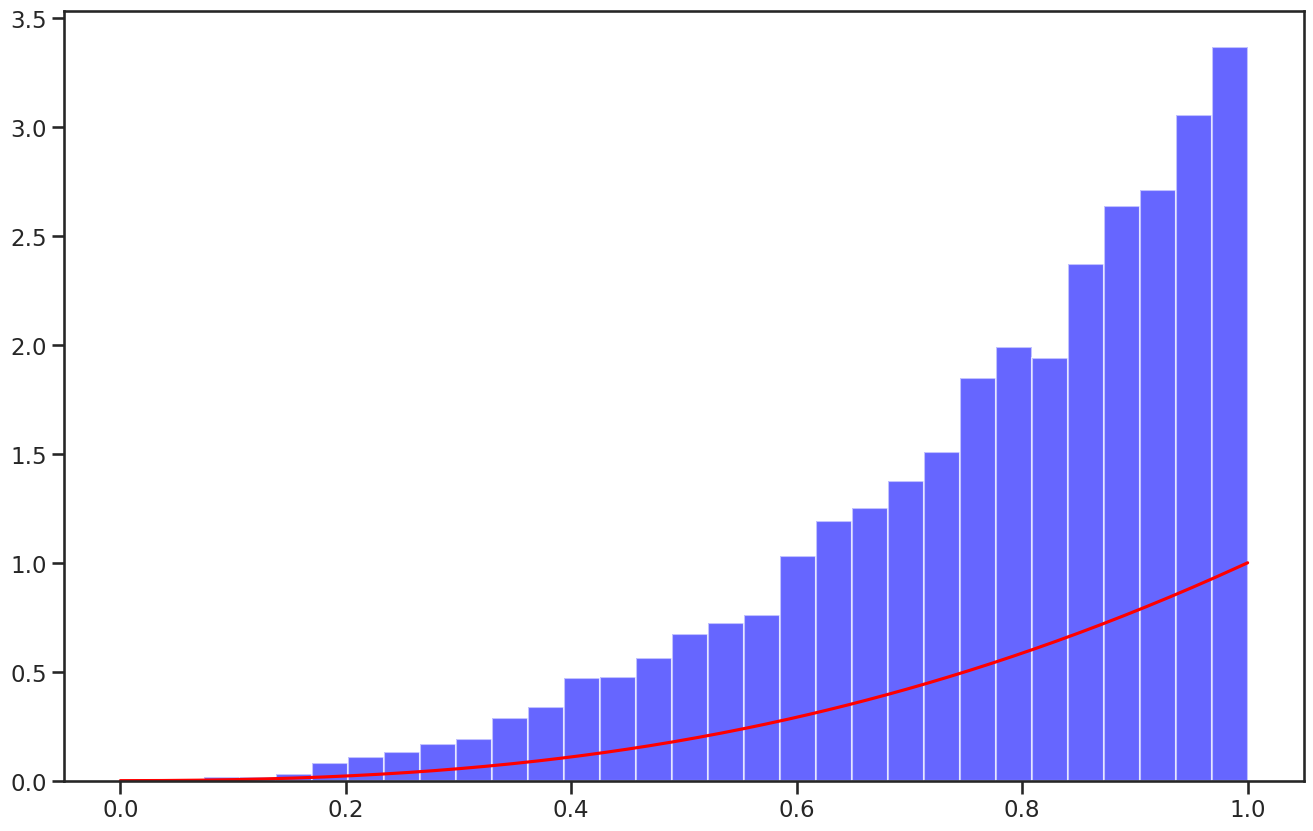

In [19]:
x = np.linspace(a, b, 1000)
plt.hist(samples, bins=30, density=True, alpha=0.6, color='blue', label='Samples')
plt.plot(x, dV_of_z_normed(x, Om0Planck, gamma=4) / (M * (b - a)), 'r-', label='Normalized PDF')
plt.savefig('pz.png')

/local/manchun.yeung@ligo.org/ipykernel_629054/2223531632.py:7: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cdf_values = cumtrapz(pdf_values, x, initial=0)  # Numerical CDF


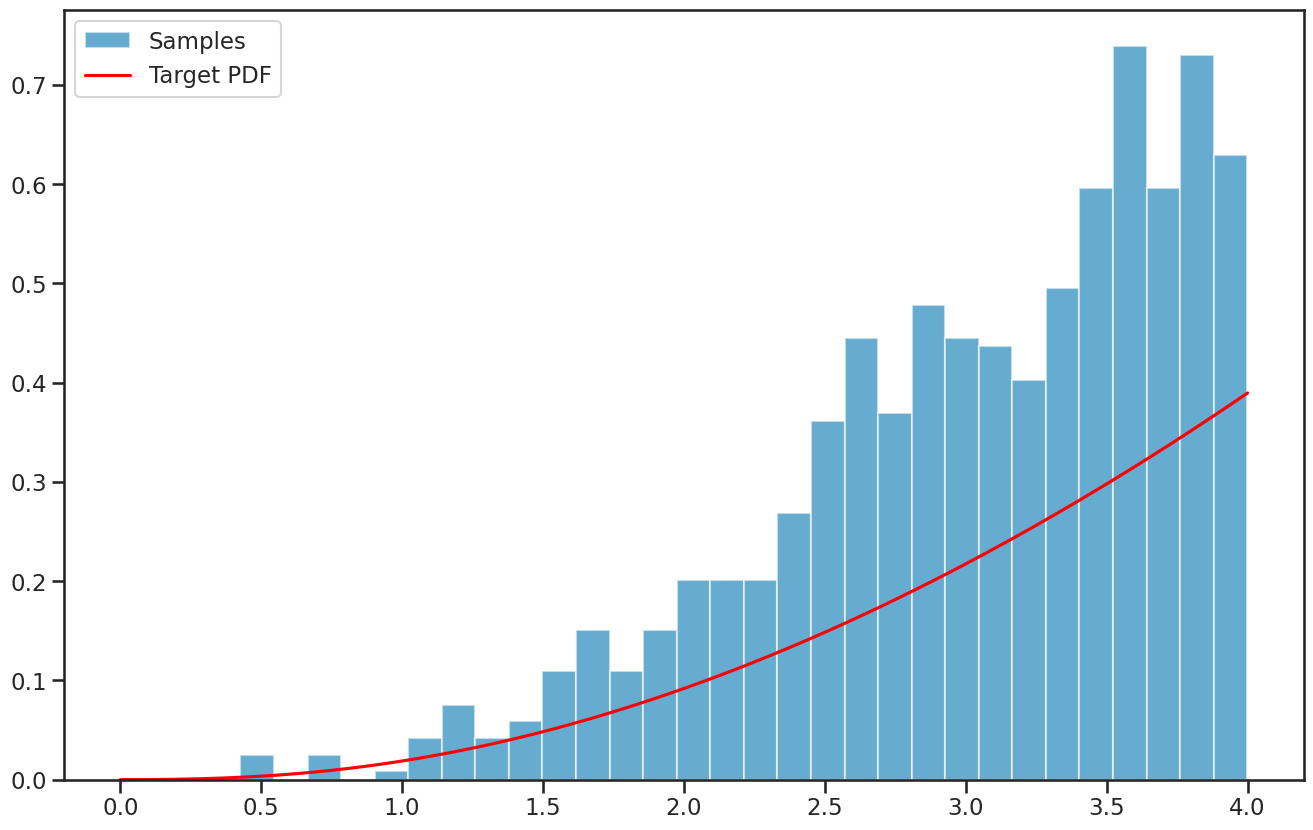

In [20]:
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

# Numerically compute the CDF
x = np.linspace(0, 4, 200)  # Range for integration
pdf_values =dV_of_z_normed(x, Om0Planck, gamma=4)
cdf_values = cumtrapz(pdf_values, x, initial=0)  # Numerical CDF
cdf_values /= cdf_values[-1]  # Normalize to [0, 1]

# Interpolate the inverse CDF
inverse_cdf = interp1d(cdf_values, x, bounds_error=False, fill_value=(x[0], x[-1]))

# Inverse Transform Sampling
def inverse_transform_sampling(n_samples):
    u = np.random.uniform(0, 1, n_samples)  # Uniform samples
    return inverse_cdf(u)  # Map to target distribution

# Generate samples
samples = inverse_transform_sampling(1000)

# Plot results
import matplotlib.pyplot as plt
plt.hist(samples, bins=30, density=True, alpha=0.6, label="Samples")
plt.plot(x, dV_of_z_normed(x, Om0Planck, gamma=4), 'r-', label="Target PDF")
plt.legend()
plt.savefig('pz.png')
plt.show()

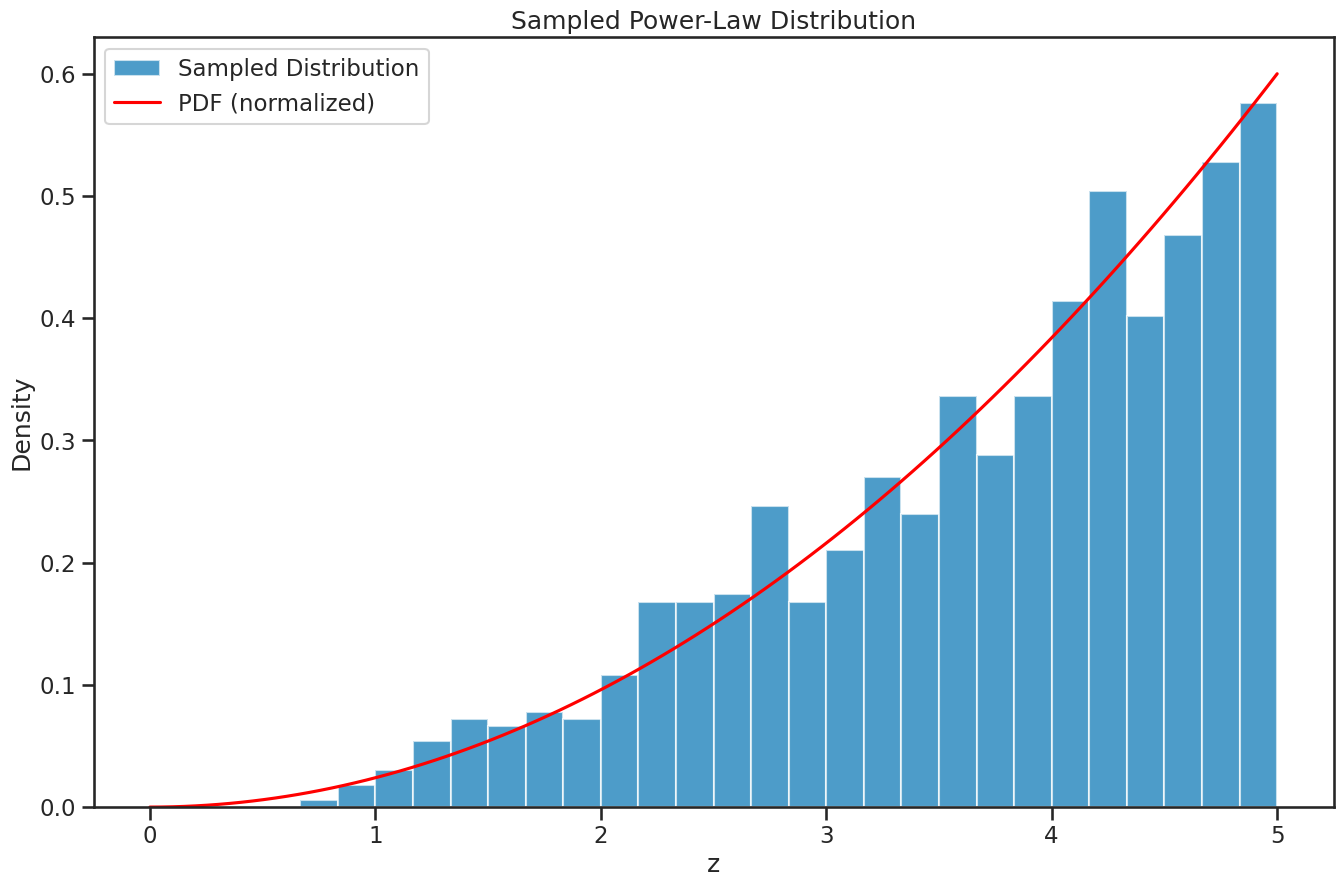

In [21]:
import numpy as np
from scipy.integrate import quad

# Power-law PDF
def power_law_pdf(z, n, zmin, zmax):
    """
    Compute the normalized power-law PDF.
    
    Parameters:
    - z: Scalar or array-like, the value(s) at which to evaluate the PDF.
    - n: Power-law index.
    - zmin, zmax: Bounds of the distribution.
    
    Returns:
    - PDF value at z.
    """
    # Avoid issues with division by zero
    if z < zmin or z > zmax:
        return 0
    # Normalization constant
    norm = np.trapz(zgrid**n,zgrid)
    pdf = zgrid**n / norm
    return np.interp(z,zgrid,pdf)
    # norm = (zmax**(n+1) - zmin**(n+1)) / (n + 1)
    # return z**n / norm

# Integrate the PDF to compute the CDF
def power_law_cdf(z, n, zmin, zmax):
    """
    Compute the CDF of the power-law PDF up to z.
    """
    # Integral of z^n from zmin to z
    if z < zmin:
        return 0
    if z > zmax:
        return 1
        
    pdf = zgrid**n / np.trapz(zgrid**n, zgrid)
    
    # Compute the CDF by integrating the PDF
    cdf_values = np.cumsum(pdf) * (zgrid[1] - zgrid[0])  # Cumulative sum (trapezoidal rule)
    cdf_values /= cdf_values[-1]
    
    # Interpolate to get the CDF value at z
    return np.interp(z, zgrid, cdf_values)

# Inverse CDF for sampling
def power_law_inverse_cdf(u, n, zmin, zmax):
    """
    Compute the inverse CDF for power-law sampling.
    
    Parameters:
    - u: Uniform random variable in [0, 1].
    - n: Power-law index.
    - zmin, zmax: Bounds of the distribution.
    
    Returns:
    - z: Sampled value.
    """
    if u < 0 or u > 1:
        raise ValueError("u must be between 0 and 1")
    
    # Compute the normalized PDF
    pdf = zgrid**n / np.trapz(zgrid**n, zgrid)
    
    # Compute the CDF by integrating the PDF
    cdf_values = np.cumsum(pdf) * (zgrid[1] - zgrid[0])  # Cumulative sum
    cdf_values /= cdf_values[-1]
    
    # Interpolate to find the z value corresponding to u
    z_sample = np.interp(u, cdf_values, zgrid)
    return z_sample


# Parameters
zmin, zmax = 0., 5.0
n = 2  # Example power-law index

zgrid = np.linspace(zmin, zmax, 1000)

# Evaluate PDF and CDF
z_values = np.linspace(zmin, zmax, 100)
pdf_values = [power_law_pdf(z, n, zmin, zmax) for z in z_values]
cdf_values = [power_law_cdf(z, n, zmin, zmax) for z in z_values]
# Sampling using the inverse CDF
np.random.seed(42)
u_samples = np.random.uniform(0, 1, 1000)  # Uniform random samples
z_samples = [power_law_inverse_cdf(u, n, zmin, zmax) for u in u_samples]

# Plotting the PDF and CDF
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(z_values, pdf_values, label="PDF")
# plt.title("Power-Law PDF")
# plt.xlabel("z")
# plt.ylabel("PDF")
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(z_values, cdf_values, label="CDF")
# plt.title("Power-Law CDF")
# plt.xlabel("z")
# plt.ylabel("CDF")
# plt.legend()

# plt.tight_layout()
# plt.show()

# Plotting the histogram of sampled values
plt.hist(z_samples, bins=30, density=True, alpha=0.7, label="Sampled Distribution", range=(zmin, zmax))
plt.plot(z_values, pdf_values, label="PDF (normalized)", color="red")
plt.title("Sampled Power-Law Distribution")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
# plt.show()
plt.savefig('pz.png')

In [24]:
def pm1_powerlaw_powerlaw(m1,m_min_1=5,m_max_1=80,alpha_1=3.3,dm_min_1=1,dm_max_1=10,mu=50,sigma=3,f1=0.4):
    p1 = jnp.exp(logpm1_powerlaw(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1))
    p2 = jnp.exp(logpm1_peak(m1,mu,sigma))

    pm1 = (1-f1)*p1 + f1*p2
    return pm1

m1 = np.linspace(0, 100, 200)
np.where(pm1_powerlaw_powerlaw(m1) == np.amax(pm1_powerlaw_powerlaw(m1)))


(array([12]),)

/local/manchun.yeung@ligo.org/ipykernel_629054/1501456919.py:10: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cdf_values = cumtrapz(pdf_values, x, initial=0)  # Numerical CDF


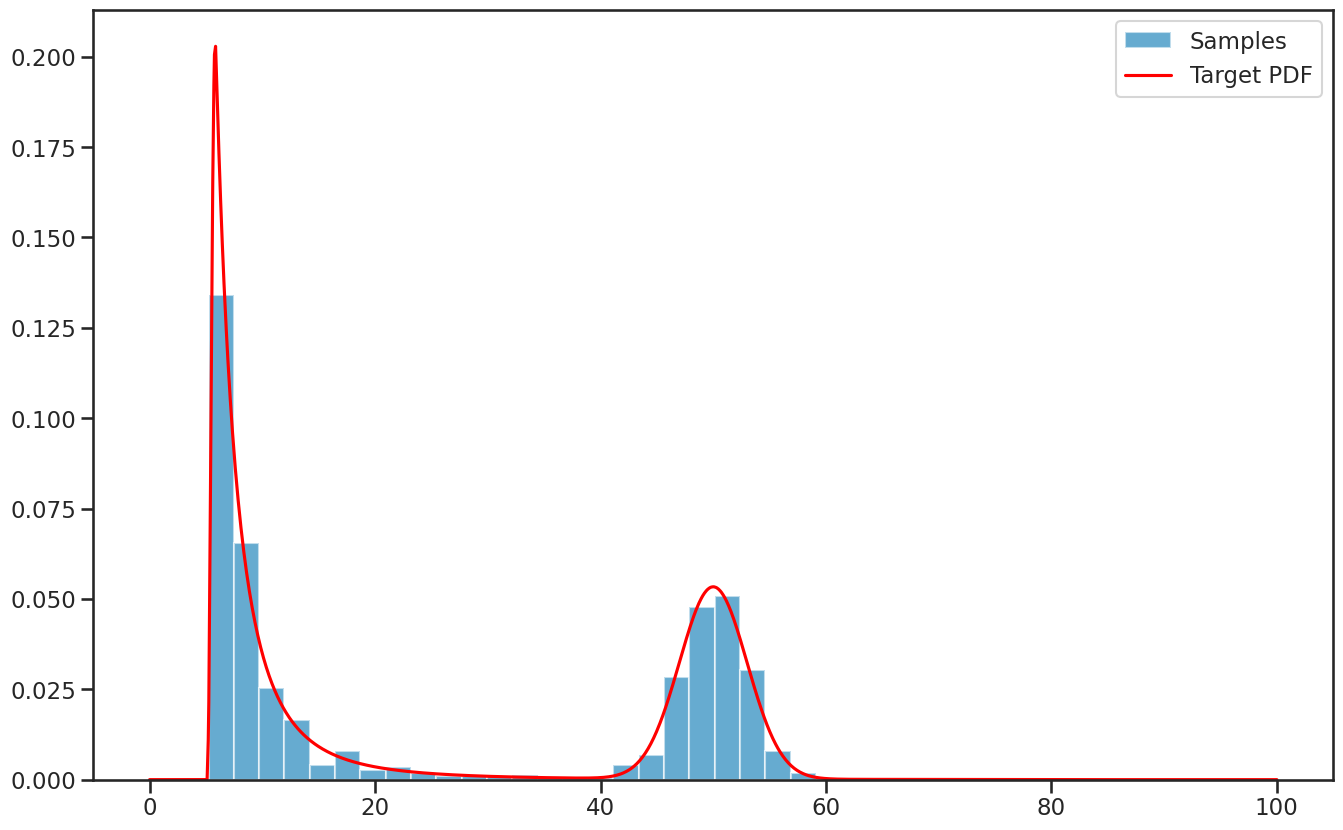

In [27]:
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

def target_pdf(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)  # Standard normal PDF

# Numerically compute the CDF
x = np.linspace(0, 100, 2000)  # Range for integration
pdf_values = pm1_powerlaw_powerlaw(x)
cdf_values = cumtrapz(pdf_values, x, initial=0)  # Numerical CDF
cdf_values /= cdf_values[-1]  # Normalize to [0, 1]

# Interpolate the inverse CDF
inverse_cdf = interp1d(cdf_values, x, bounds_error=False, fill_value=(x[0], x[-1]))

# Inverse Transform Sampling
def inverse_transform_sampling(n_samples):
    u = np.random.uniform(0, 1, n_samples)  # Uniform samples
    return inverse_cdf(u)  # Map to target distribution

# Generate samples
samples = inverse_transform_sampling(1000)

# Plot results
import matplotlib.pyplot as plt
plt.hist(samples, bins=30, density=True, alpha=0.6, label="Samples")
plt.plot(x, pm1_powerlaw_powerlaw(x), 'r-', label="Target PDF")
plt.legend()
plt.savefig('pm1.png')
plt.show()

In [37]:
# mass_ratio = np.linspace(0, 1, 2000)
# def cond_pq(m1, m2, beta=3):

#     q = m2/m1
#     # q = m2[m2<m1]/m1[m2<m1]
#     # print(q.shape)
#     # nm1 = m1[m2<m1]
#     # nm2 = m2[m2<m1]
    
#     cond_pq = mass_ratio**beta
#     cond_pq = cond_pq/jnp.trapezoid(cond_pq,mass_ratio)

#     cond_pq = jnp.interp(q,mass_ratio,cond_pq)

#     # joint_pq = cond_pq * pm1_powerlaw_powerlaw(nm1) * pm1_powerlaw_powerlaw(nm2)
    
#     # pq_om1 = np.trapz(cond_pq * pm1_powerlaw_powerlaw(nm1), nm1)
#     # pq = np.trapz(pq_om1 * pm1_powerlaw_powerlaw(nm2), nm2)

#     # print(joint_pq, joint_pq.shape)
    
#     # marginal_pq = np.sum(joint_pq, axis=(0, 1))  # Sum over both m1 and m2
#     # marginal_pq /= np.sum(marginal_pq)  # Normalize p(q)

#     return cond_pq

1
[0.99       0.9037156  0.83126582 ... 0.04997717 0.04973744 0.0495    ]


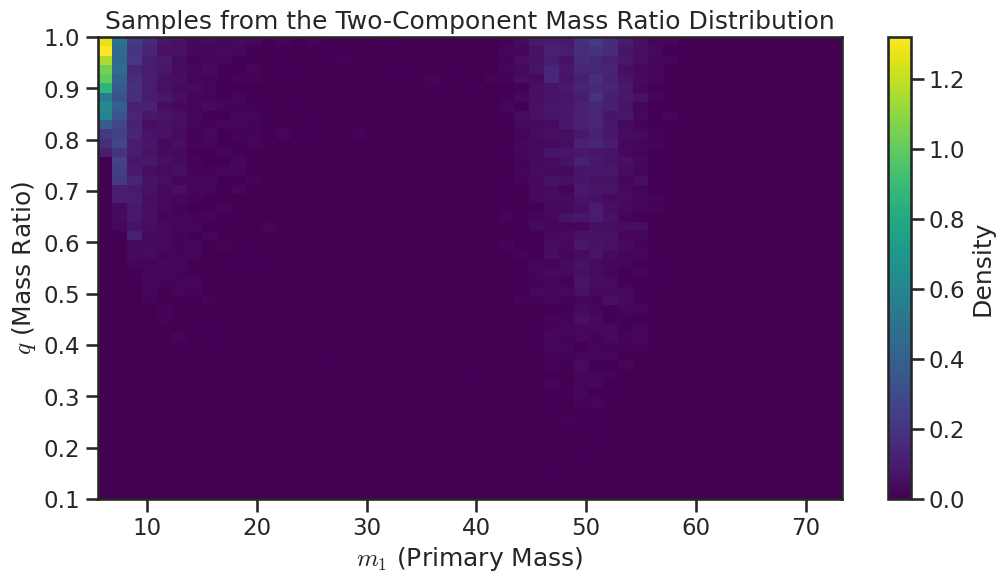

In [71]:
def powerlaw(xx, beta, high, low):
    print(high)
    print(low)
    norm = np.where(
        np.array(alpha) == -1,
        1 / np.log(high / low),
        (1 + alpha) / np.array(high ** (1 + alpha) - low ** (1 + alpha)),
    )
    prob = np.power(xx, alpha)
    prob *= norm
    prob *= (xx <= high) & (xx >= low)
    return prob

def two_component_primary_mass_ratio(
    dataset, alpha, beta, mmin, mmax, lam, mpp, sigpp, gaussian_mass_maximum=100
):
    r"""
    Power law model for two-dimensional mass distribution, modelling primary
    mass and conditional mass ratio distribution.

    .. math::
        p(m_1, q) = p(m1) p(q | m_1)

    """
    beta=2
    params = dict(
        mmin=mmin,
        mmax=mmax,
        lam=lam,
        mpp=mpp,
        sigpp=sigpp,
        gaussian_mass_maximum=gaussian_mass_maximum,
    )
    p_m1 = pm1_powerlaw_powerlaw(dataset["mass_1"])
    p_q = powerlaw(dataset["mass_ratio"], beta, 1, 4.95/dataset["mass_1"])
    prob = p_m1 * p_q
    return prob

n_samples = 10000
m1_range = np.linspace(5, 100, 200)  # Example range for primary mass
q_range = np.linspace(0.1, 1, 200)  # Example range for mass ratio

m1_grid, q_grid = np.meshgrid(m1_range, q_range)
dataset = {
    "mass_1": m1_grid.ravel(),
    "mass_ratio": q_grid.ravel(),
}

p_joint = two_component_primary_mass_ratio(dataset, alpha, beta, mmin, mmax, lam, mpp, sigpp).reshape(len(q_range), len(m1_range))

# Step 2: Normalize and compute the CDF
p_joint /= np.sum(p_joint)  # Normalize the joint probability
cdf = np.cumsum(p_joint.ravel())  # Flatten and compute cumulative sum
cdf /= cdf[-1]  # Normalize the CDF to [0, 1]

# Step 3: Sample from the CDF
uniform_samples = np.random.uniform(0, 1, n_samples)
sample_indices = np.searchsorted(cdf, uniform_samples)
sample_q_indices, sample_m1_indices = np.unravel_index(sample_indices, p_joint.shape)

sample_m1 = m1_range[sample_m1_indices]
sample_q = q_range[sample_q_indices]

# Step 4: Plot the results
plt.figure(figsize=(12, 6))
plt.hist2d(sample_m1, sample_q, bins=50, density=True, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('$m_1$ (Primary Mass)')
plt.ylabel('$q$ (Mass Ratio)')
plt.title('Samples from the Two-Component Mass Ratio Distribution')
plt.show()


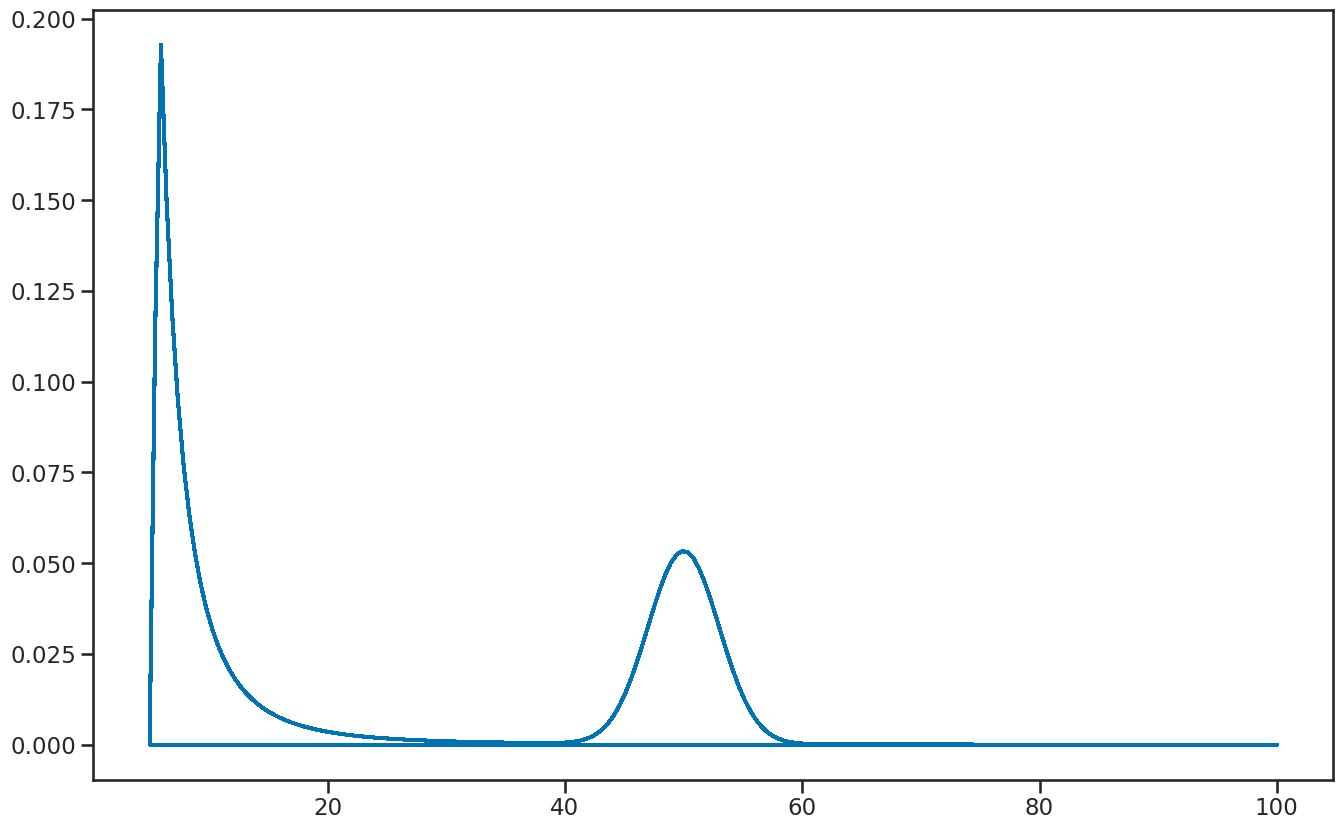

In [73]:
plt.plot(dataset["mass_1"], pm1_powerlaw_powerlaw(dataset["mass_1"]))